## Setup 

In [1]:
from vector_database.src.text_splitter import chunk_documents
from vector_database.src.utils import load_config

from dotenv import load_dotenv
from pathlib import Path

# 1. Load environment
load_dotenv()

# 2. Load config
config_path = Path("config.yaml")
config = load_config(config_path)


## Download documents only if needed

In [2]:
from vector_database.src.documentation_loader import clone_repo, cleanup_old_outputs

# 3. If you want to download the docs from GitHub again, run this:
cleanup_old_outputs()
clone_repo(config)



Target path /Users/manuelalejandroquesada/PERSONAL/REPOSITORIES/langgraph_documentation_RAG/docs/source_docs already exists. Removing for fresh clone.
Copying from local cache langgraph_repo/docs/docs to /Users/manuelalejandroquesada/PERSONAL/REPOSITORIES/langgraph_documentation_RAG/docs/source_docs...


## Load the Documents and Analyze the Statistics

In [3]:
from vector_database.src.documentation_loader import load_documents
import numpy as np

# 4. Load documents
docs_path = config['data_source']['github']['target_path']
all_docs = load_documents(docs_path)
len_docs = [len(doc.page_content) for doc in all_docs]

arr = np.array(len_docs)

# Calculate statistics
count = len(arr)
minimum = np.min(arr)
maximum = np.max(arr)
average = np.mean(arr)
q1 = np.percentile(arr, 25)
q2 = np.percentile(arr, 50)
q3 = np.percentile(arr, 75)
below_q1 = np.sum(arr < q1)
below_q2 = np.sum(arr < q2)
below_q3 = np.sum(arr < q3)

# Print results
print(f"Total number of documents: {count}")
print(f"Minimum of document length: {minimum}")
print(f"Average of document length: {average:.2f}")
print(f"Maximum of document length: {maximum}")
print(f"Q1 (25th percentile): {q1}")
print(f"Values below Q1: {below_q1}")
print(f"Q2 (50th percentile): {q2}")
print(f"Values below Q2: {below_q2}")
print(f"Q3 (75th percentile): {q3}")
print(f"Values below Q3: {below_q3}")



Total number of documents: 184
Minimum of document length: 264
Average of document length: 10370.11
Maximum of document length: 88210
Q1 (25th percentile): 3306.0
Values below Q1: 46
Q2 (50th percentile): 7471.0
Values below Q2: 92
Q3 (75th percentile): 13031.5
Values below Q3: 138


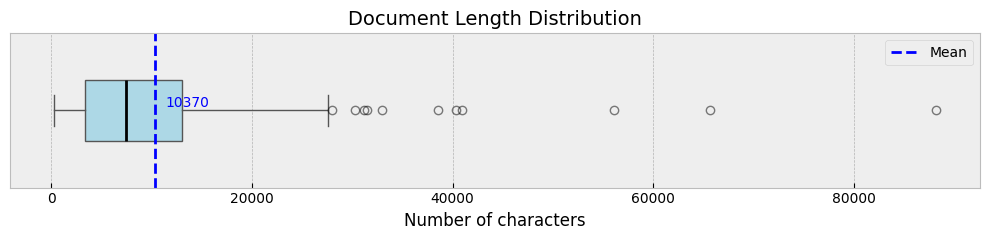

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(10, 2.5))

box = ax.boxplot(
    arr,
    vert=False,
    patch_artist=True,
    widths=0.4,
    boxprops=dict(facecolor='#add8e6', color='#555555'),
    whiskerprops=dict(color='#555555'),
    capprops=dict(color='#555555'),
    medianprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='o', color='red', alpha=0.5)
)
{'baseline', 'bottom', 'center', 'center_baseline', 'top'}
ax.axvline(average, color='blue', linestyle='--', linewidth=2, label='Mean')

ax.text(average + 1000, 1, f'{average:.0f}',
        color='blue', va='bottom', ha='left', fontsize=10)

ax.set_xlabel("Number of characters", fontsize=12)
ax.set_yticks([])  # hide y-axis
ax.set_title("Document Length Distribution", fontsize=14)

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("boxplot.png", dpi=300)
plt.show()

## Split documents

Since approximately 10000 characters corresponds to the midpoint (50th percentile) of document lengths, we consider the half of this value appropriate to establish as a threshold for chunking. For overlapping we will use 800 as we want to avoid splitting ideas in the middle, and especially avoid breaking up code blocks.

In [5]:

# 5. Chunk and save
from vector_database.src.text_splitter import save_chunks_to_disk


chunks = chunk_documents(all_docs, config)
print(len(chunks))
# save_chunks_to_disk(chunks)

581


## Populate Qdrant Vector Database
Only needed the first time that you ingest your documents

In [7]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

from vector_database.src.vector_store import COLLECTION_NAME, get_vector_store


vector_store = get_vector_store()


In [ ]:
vector_store.add_documents(chunks)

## Initializate the RAG Pipeline

In [9]:
from rag_pipeline.core import RAGPipeline
from prompts.core import PromptBuilder
from langgraph.checkpoint.memory import MemorySaver

builder = PromptBuilder(config_path="prompts/config.yaml")

rag_config = {"configurable": {"thread_id": "test"}}

topic_guard_prompt, _ = builder.build_prompt(
    file_path="prompts/topic_guard.yml")
rag_system_prompt, _ = builder.build_prompt(
    file_path="prompts/rag_system_prompt.yml")

checkpointer = MemorySaver()  # only for testing, for production use `PostgresSaver`


rag = RAGPipeline(
    checkpoint=checkpointer,
    vectorstore=vector_store,
    topic_guard_prompt=topic_guard_prompt,
    rag_system_prompt=rag_system_prompt,
    llm_temperature=0.1,
    llm_model_name="gpt-4o-mini",
    num_history_messages=5,
    num_retrieval_chunks=3,
)

## Chat Simulation

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown


# Input widget
input_box = widgets.Text(
    value='',
    placeholder='Type your question and press Enter...',
    description='User:',
    layout=widgets.Layout(width='100%')
)

# Output widget
output_box = widgets.Output()

# Handler for Enter key


def on_submit_enter(text):
    question = input_box.value
    answer, sources = rag.chat(question, config=rag_config)
    with output_box:
        display(Markdown(f"**🧑 User:** {question}"))
        if sources:
            sources = " -- ".join([f"`{_}`" for _ in sources])
            display(Markdown(f"**📚 Sources:** {sources}"))
        # This will render the bot's response as Markdown
        display(Markdown(f"**🤖 Bot:**\n {answer}"))
        display(Markdown("---"))
    input_box.value = ''


# Trigger on Enter
input_box.on_submit(on_submit_enter)

# Show interface
display(input_box)
display(output_box)

/var/folders/wf/r36br2vs18bdnw4y1vjw_7sc0000gn/T/ipykernel_35992/2130190200.py:34: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit_enter)


Text(value='', description='User:', layout=Layout(width='100%'), placeholder='Type your question and press Ent…

Output()